In [5]:
import pandas as pd
from pulp import *
import matplotlib.pyplot as plt
from itertools import chain, repeat

In [6]:
def ncycles(iterable, n):
    "Returns the sequence elements n times"
    return chain.from_iterable(repeat(tuple(iterable), n))

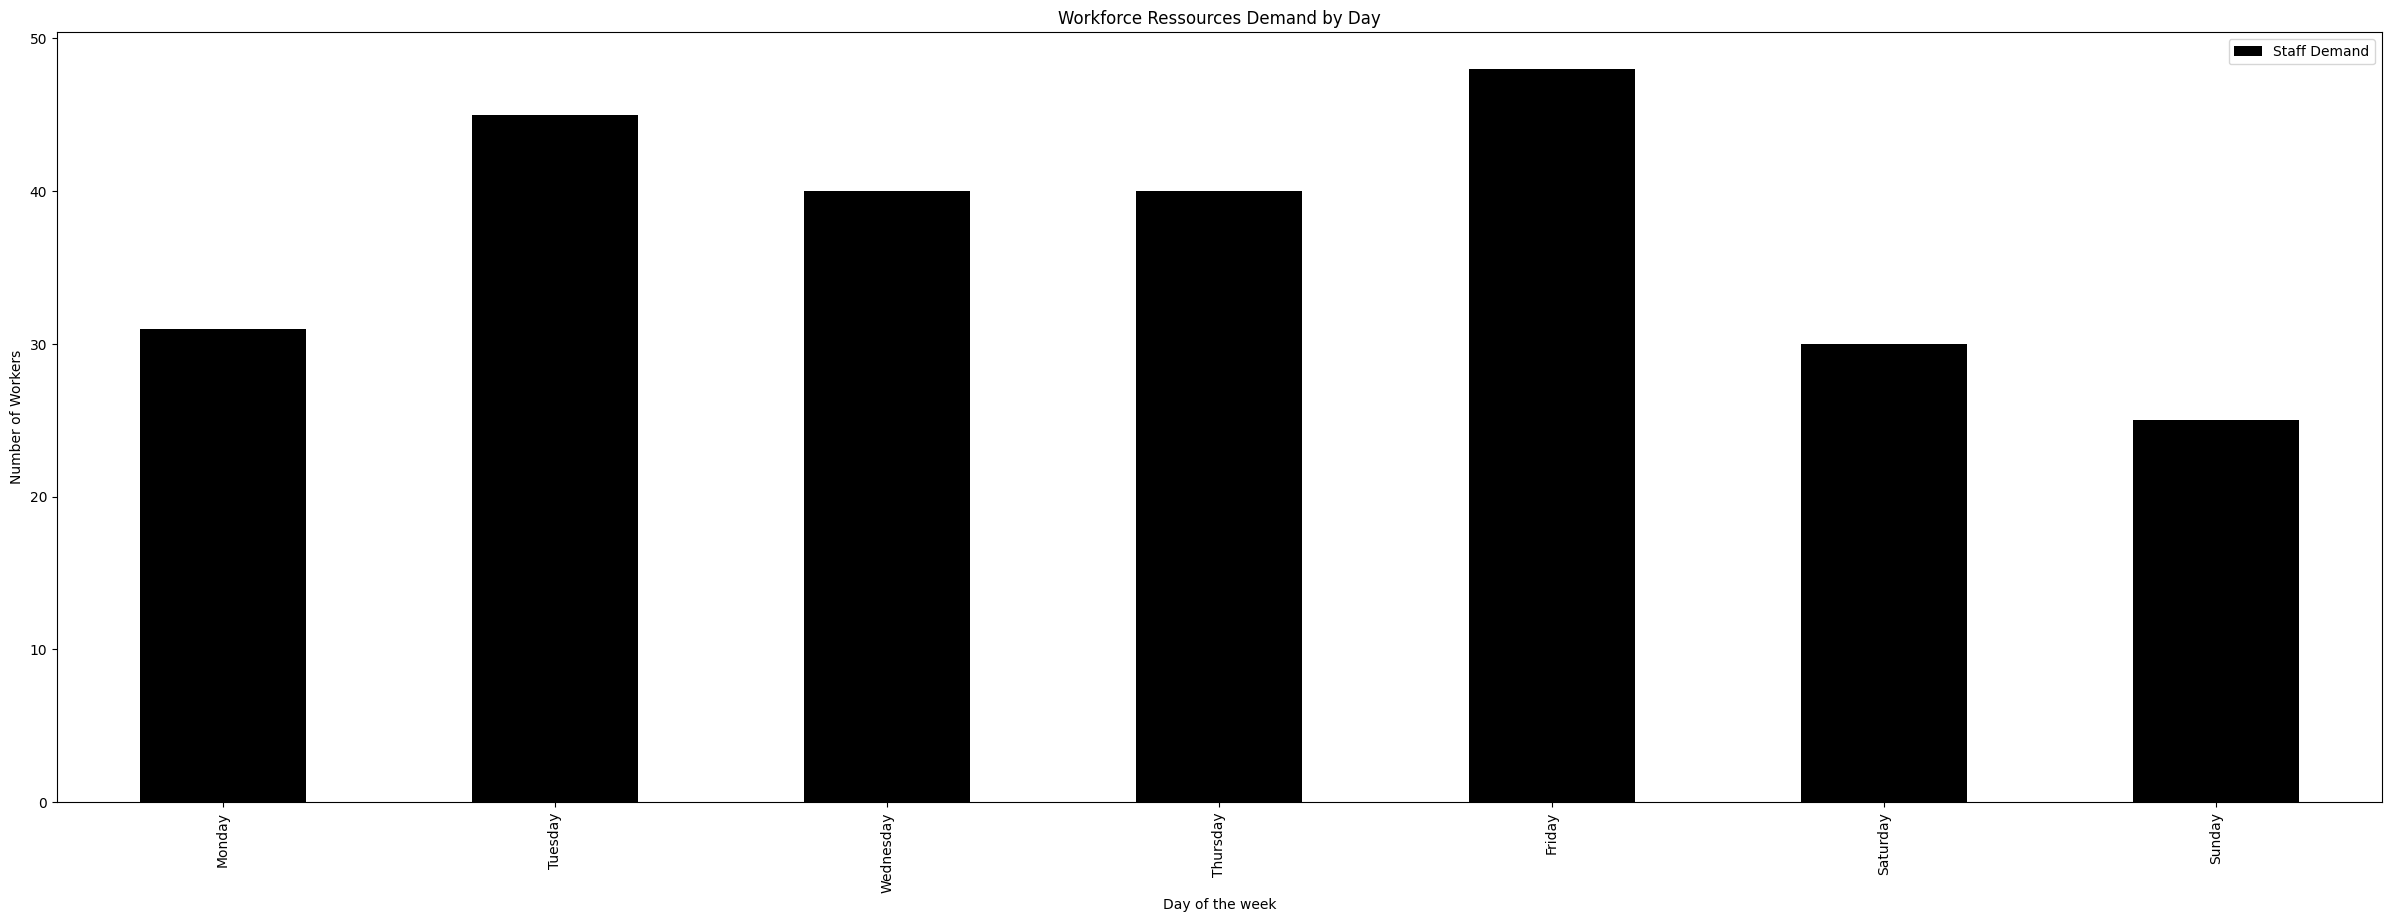

In [7]:
n_staff = [31, 45, 40, 40, 48, 30, 25]
jours = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Staff
df_staff = pd.DataFrame({'Days': jours, 'Staff Demand':n_staff})
df_staff[['Days', 'Staff Demand']].plot.bar(x='Days', figsize = (30, 10), fill=True, color='black')
plt.title('Workforce Ressources Demand by Day')
plt.xlabel('Day of the week')
plt.ylabel('Number of Workers')
plt.show()

In [8]:
n_days = [i for i in range(7)]
n_days_c = list(ncycles(n_days, 3)) 

# Working days
list_in = [[n_days_c[j] for j in range(i , i + 5)] for i in n_days_c]

# Days off
list_excl = [[n_days_c[j] for j in range(i + 1, i + 3)] for i in n_days_c]

In [9]:
# The class has been initialize, and x, and days defined
model = LpProblem("Minimize Staffing", LpMinimize)

# Create Variables
start_jours = ['Shift: ' + i for i in jours]
x = LpVariable.dicts('shift_', n_days, lowBound=0, cat='Integer')

# Define Objective
model += lpSum([x[i] for i in n_days])

# Add constraints
for d, l_excl, staff in zip(n_days, list_excl, n_staff):
    model += lpSum([x[i] for i in n_days if i not in l_excl]) >= staff

# Solve Model
model.solve()

# The status of the solution is printed to the screen
print("Status:", LpStatus[model.status])

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/pranaymishra/Desktop/care/.conda/lib/python3.10/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/0d/srwhm0y53j14k9ypbh_kj7v40000gn/T/e99461d600c34b108c4683b8ce850a46-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/0d/srwhm0y53j14k9ypbh_kj7v40000gn/T/e99461d600c34b108c4683b8ce850a46-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 12 COLUMNS
At line 69 RHS
At line 77 BOUNDS
At line 85 ENDATA
Problem MODEL has 7 rows, 7 columns and 35 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 52.6667 - 0.00 seconds
Cgl0003I 0 fixed, 7 tightened bounds, 0 strengthened rows, 0 substitutions
Cgl0004I processed model has 7 rows, 7 columns (7 integer (0 of which binary)) and 35 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0012I Integer solution of 54 fo

/Users/pranaymishra/Desktop/care/.conda/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


In [10]:
dct_work = {}
dico_work = {}
for v in model.variables():
    dct_work[int(v.name[-1])] = int(v.varValue)
    dico_work[v.name] = int(v.varValue)
dico_work

{'shift__0': 14,
 'shift__1': 14,
 'shift__2': 8,
 'shift__3': 0,
 'shift__4': 13,
 'shift__5': 0,
 'shift__6': 4}

In [11]:
# Show workers schedule
dict_sch = {}
for day in dct_work.keys():
    dict_sch[day] = [dct_work[day] if i in list_in[day] else 0 for i in n_days]
df_sch = pd.DataFrame(dict_sch).T
df_sch.columns = jours
df_sch.index = start_jours
# The optimized objective function value is printed to the screen
print("Total number of Staff = ", pulp.value(model.objective))

Total number of Staff =  53.0


In [12]:
df_sch

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Shift: Monday,14,14,14,14,14,0,0
Shift: Tuesday,0,14,14,14,14,14,0
Shift: Wednesday,0,0,8,8,8,8,8
Shift: Thursday,0,0,0,0,0,0,0
Shift: Friday,13,13,0,0,13,13,13
Shift: Saturday,0,0,0,0,0,0,0
Shift: Sunday,4,4,4,4,0,0,4


In [13]:
df_sch.sum(axis =0)

Monday       31
Tuesday      45
Wednesday    40
Thursday     40
Friday       49
Saturday     35
Sunday       25
dtype: int64

In [14]:
df_supp = df_staff.copy().set_index('Days')
df_supp['Staff Supply'] = df_sch.sum(axis = 0)
df_supp['Extra_Ressources'] = df_supp['Staff Supply'] - df_supp['Staff Demand']
df_supp.to_csv('test.csv')

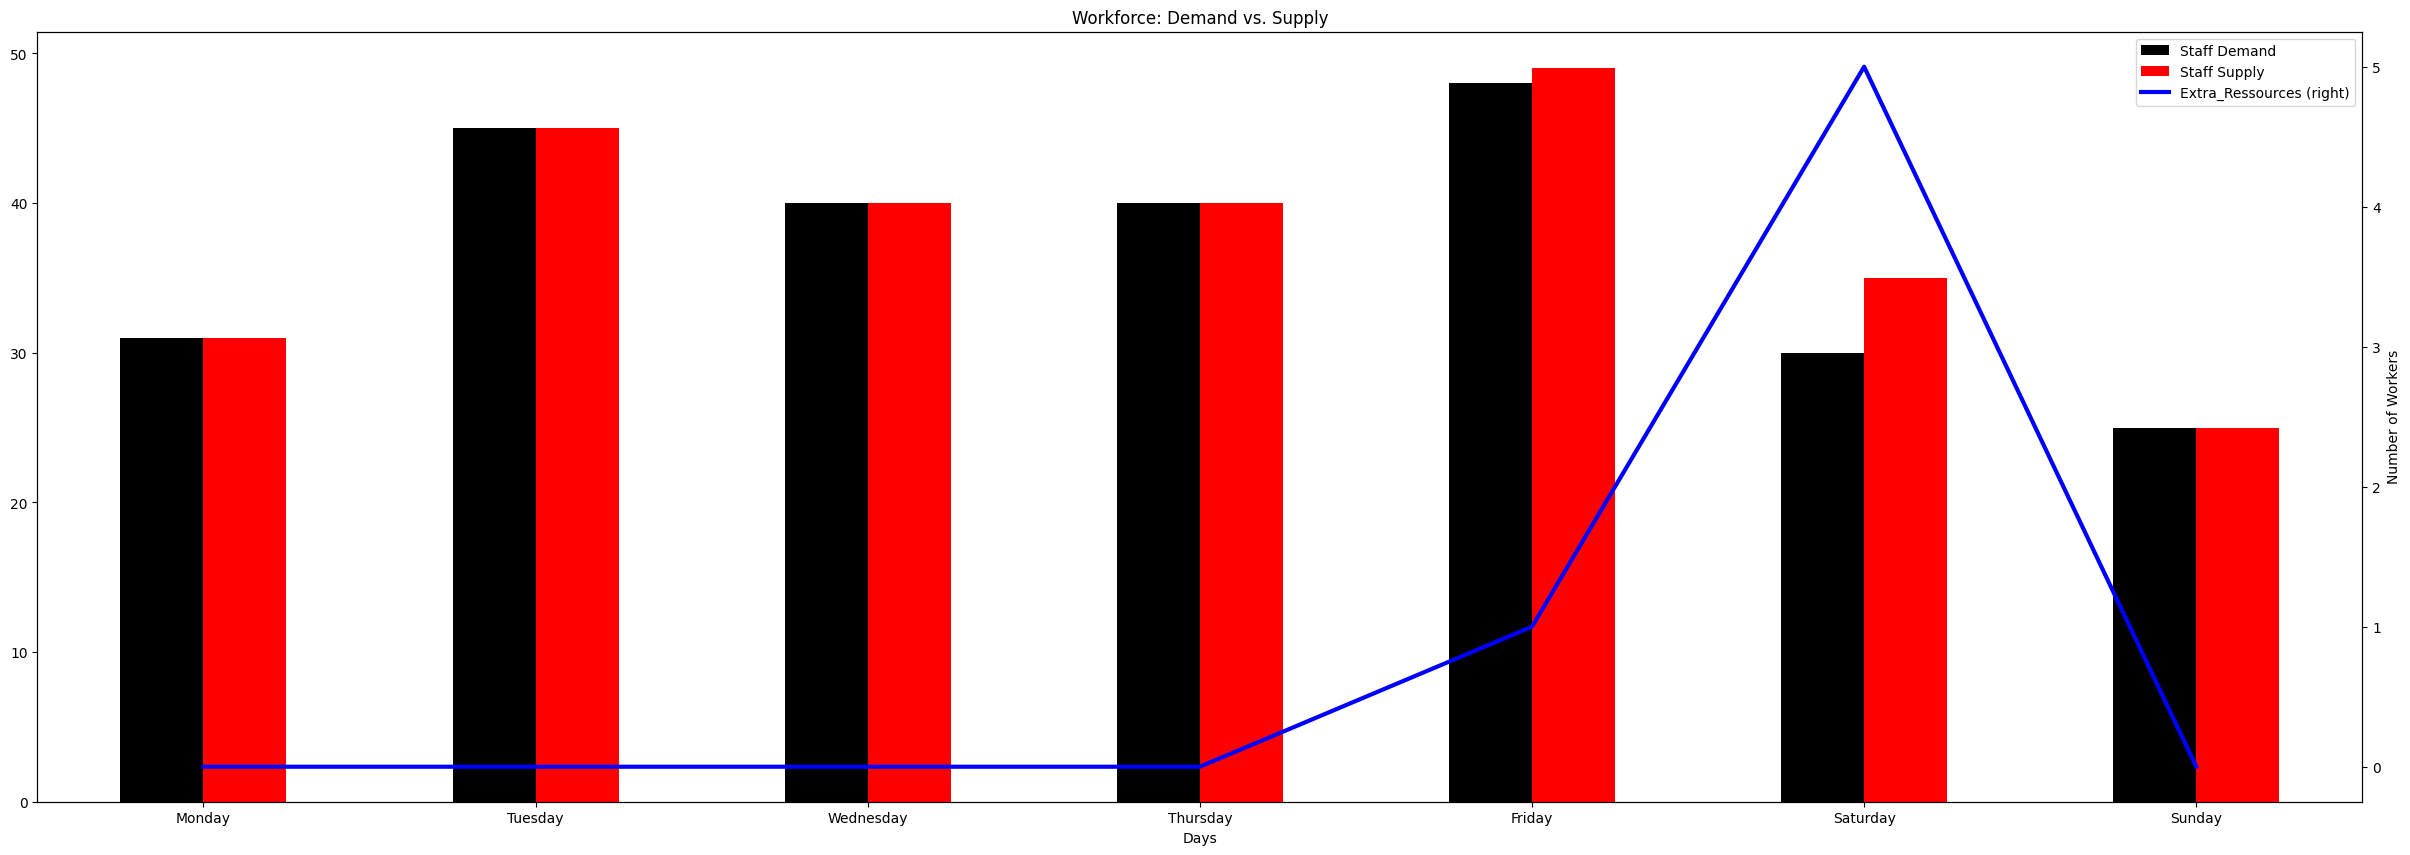

In [15]:
ax = df_supp.plot.bar(y=['Staff Demand', 'Staff Supply'], figsize = (30, 10), fill=True, color=['black', 'red'])
df_supp.plot(y=['Extra_Ressources'], color=['blue'], secondary_y = True, ax = ax, linewidth = 3)
plt.title('Workforce: Demand vs. Supply')
plt.xlabel('Day of the week')
plt.ylabel('Number of Workers')
plt.show()